## Fine Tuning Pipeline

### 1. Loading the model and configurations

In [1]:
validation_year = 2022
validation_2020 = True

In [2]:
import json
pretrained_model_path = 'exp3_models/model_0.407_2_aug_medium'
with open(pretrained_model_path + '/hyperparameters.json') as f:
    hyperparameters = json.load(f)


### 2. Loading the 2022 dataset with correct configurations

In [3]:
import zipfile
import tqdm

def read_zip_archive(zip_file_path, contents, names, ips):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        for file_name in tqdm.tqdm(file_list):
            if (not file_name.endswith('.csv')):
                continue
            name = file_name.split('/')[-1]
            feature_name = file_name.split('/')[-2]
            if (feature_name != hyperparameters["feature"]):
                continue
            name = name.split('.csv')[0]
            ip1 = name.split('-')[0]
            ip2 = name.split('-')[1]
            names.append(name)
            ips.add(ip1)
            ips.add(ip2)
            # Read the content of each file into a list of strings
            with zip_ref.open(file_name) as file:
                content = file.read().decode('utf-8')  # Assuming the content is in UTF-8 encoding
                contents.append(content)
    return contents, names, ips


contents = []
names = []
ips = set()

burst_timeout = 'x' if hyperparameters['word_type'] == 'p' else str(hyperparameters['burst_timeout'])

print('Reading year 2022')
path = 'config_' + hyperparameters['sentence_type'] + hyperparameters['word_type'] + '_' + str(hyperparameters["hp_filter_size"]) + '_' + burst_timeout + '_' + str(hyperparameters["sentence_timeout"]) + '.zip'
contents, names, ips = read_zip_archive(str(validation_year) + '/' + path, contents, names, ips)


Reading year 2022


100%|██████████| 199091/199091 [00:05<00:00, 37692.95it/s] 


In [4]:
import pandas as pd
ip_labels = pd.read_csv('ip_labels.txt', header=None, names=['ip', 'label'])
ip_label_dict = ip_labels.set_index('ip')['label'].to_dict()


### 2b Load 2020 (2021-FC) validation data

In [5]:
teamserver_1 = [
    "37.157.123.51",
    "37.157.127.17",
    "2a00:16e0:100:0:7abd:2745:d741:c8a0",
    "2001:1bf1:0:0:9256:f3bb:eb24:fb84",
    "185.20.58.178",
    "46.131.46.67",
    "2a04:80c2:0:0:738b:3848:25e4:800c",
    "2a07:1182:1000:1002:19a7:df71:7fe7:6522",
    "94.246.252.193",
]

if validation_2020:
    contents_2020 = []
    names_2020 = []
    ips_2020 = set()
    contents_2020, names_2020, ips_2020 = read_zip_archive(str(2020) + '/' + path, contents_2020, names_2020, ips_2020)

    teamserver_documents = []
    for content, name in zip(contents_2020, names_2020):
        if any(ip in name for ip in teamserver_1):
            teamserver_documents.append(content)
        
    benign_2020 = []
    for ip in ips_2020:
        if ip in ips and ip_label_dict[ip] == 3:
            benign_2020.append(ip)
    benign_2020_documents = []
    for content, name in zip(contents_2020, names_2020):
        if any(ip in name for ip in benign_2020):
            benign_2020_documents.append(content)

100%|██████████| 115055/115055 [00:20<00:00, 5608.83it/s]


### 3. Preprocessing I

In [6]:
# TODO

### 4. Bucketize the Dataset

In [7]:
import numpy as np

num_buckets = hyperparameters["num_buckets"]
min_buckets = hyperparameters["bucket_min"]
max_buckets = hyperparameters["bucket_max"]
bucket_boundaries = np.linspace(min_buckets, max_buckets, num_buckets)

def bucket_id_from_decimal(decimal):
    return np.digitize(decimal, bucket_boundaries) + 4 # five reserved tokens, 0-4, digitize starts at 1

corpus = []
for content in tqdm.tqdm(contents):
    document = []
    corpus.append(document)
    for sentence_id, row in enumerate(content.split('\n')):
        if sentence_id > hyperparameters['doc_length']:
            break
        sentence = []
        for i, value in enumerate(row.split(' ')):
            if i > hyperparameters['seq_length']:
                break
            if value == '':
                continue
            value = float(value)
            sentence.append(bucket_id_from_decimal(value))
        document.append(sentence)


  0%|          | 114/99544 [00:00<01:44, 955.70it/s]

100%|██████████| 99544/99544 [01:13<00:00, 1358.24it/s]


In [8]:
if validation_2020:
    teamserver_corpus = []
    for content in tqdm.tqdm(teamserver_documents):
        document = []
        teamserver_corpus.append(document)
        for sentence_id, row in enumerate(content.split('\n')):
            if sentence_id > hyperparameters['doc_length']:
                break
            sentence = []
            for i, value in enumerate(row.split(' ')):
                if i > hyperparameters['seq_length']:
                    break
                if value == '':
                    continue
                value = float(value)
                sentence.append(bucket_id_from_decimal(value))
            document.append(sentence)
            
    benign_2020_corpus = []
    for content in tqdm.tqdm(benign_2020_documents):
        document = []
        benign_2020_corpus.append(document)
        for sentence_id, row in enumerate(content.split('\n')):
            if sentence_id > hyperparameters['doc_length']:
                break
            sentence = []
            for i, value in enumerate(row.split(' ')):
                if i > hyperparameters['seq_length']:
                    break
                if value == '':
                    continue
                value = float(value)
                sentence.append(bucket_id_from_decimal(value))
            document.append(sentence)

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 8033/8033 [00:28<00:00, 280.16it/s]


### 5. Preprocessing II: Filter out all irrelevant traffic

In [9]:
# 0: internal, 1: firewall, 2: rt, 3: other
# only allow rt-internal and rt-firewall as rt (label 0)
# use internal-other and firewall-other as other (label 1)
def label_rule(label1, label2):
    if label1 == 0 and label2 == 2 or label2 == 0 and label1 == 2 or label1 == 1 and label2 == 2 or label2 == 1 and label1 == 2:
        return 0
    if label1 == 0 and label2 == 3 or label2 == 0 and label1 == 3 or label1 == 1 and label2 == 3 or label2 == 1 and label1 == 3:
        return 1
    return 2

cleaned_corpus = []
labels = []
for name, document in zip(names, corpus):
    ip1 = name.split('-')[0]
    ip2 = name.split('-')[1]
    label1 = ip_label_dict[ip1]
    label2 = ip_label_dict[ip2]
    label = label_rule(label1, label2)
    if label == 2:
        continue
    labels.append(label)
    cleaned_corpus.append(document)

### 6. Validation Split

In [10]:
from sklearn.model_selection import train_test_split
import numpy as np


combined = list(zip(cleaned_corpus, labels))
np.random.shuffle(combined)
cleaned_corpus_shuffled, labels_shuffled = zip(*combined)

train_corpus, validation_corpus, train_labels, validation_labels = train_test_split(cleaned_corpus_shuffled, labels_shuffled, test_size=0.2, random_state=42, stratify=labels_shuffled)

### 7. BERT Finetuning

In [11]:
from bert_class_dataset import BERTClassDataset

train_data = BERTClassDataset(train_corpus, train_labels, seq_length=hyperparameters['seq_length'], augment=False)
eval_data = BERTClassDataset(validation_corpus, validation_labels, seq_length=hyperparameters['seq_length'], augment=False)

77180it [00:01, 40741.40it/s] 
19295it [00:00, 19399.32it/s] 


In [12]:
if validation_2020:
    teamserver_data = BERTClassDataset(teamserver_corpus, [0] * len(teamserver_corpus), seq_length=hyperparameters['seq_length'], augment=False)
    benign_2020_data = BERTClassDataset(benign_2020_corpus, [1] * len(benign_2020_corpus), seq_length=hyperparameters['seq_length'], augment=False)

27it [00:00, 19471.49it/s]
5727it [00:00, 27540.91it/s]

8033it [00:01, 6195.11it/s] 


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_path, num_labels=2)

import os
finetune_model_path = "checkpoints_finetuning"
folders = os.listdir(finetune_model_path)
ids = [int(folder.split('_')[-1]) for folder in folders]
max_id = max(ids) if ids else 0
finetune_model_path = os.path.join(finetune_model_path, f"model_{max_id + 1}")
try:
    os.mkdir(finetune_model_path)
except:
    pass

training_args = TrainingArguments(
    output_dir=finetune_model_path,          # output directory to where save model checkpoint
    evaluation_strategy="steps",    # evaluate each `logging_steps` steps
    overwrite_output_dir=True,      
    num_train_epochs=5,            # number of training epochs, feel free to tweak
    per_device_train_batch_size=32, # the training batch size, put it as high as your GPU memory fits
    gradient_accumulation_steps=8,  # accumulating the gradients before updating the weights
    per_device_eval_batch_size=128,  # evaluation batch size
    logging_steps=1000,             # evaluate, log and save model checkpoints every 1000 step
    save_steps=1000,
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    load_best_model_at_end=True,
    save_total_limit=3,
    
    # do_eval=False,
    # load_best_model_at_end=True,  # whether to load the best model (in terms of loss) at the end of training
    # save_total_limit=3,           # whether you don't have much space so you let only 3 model weights saved in the disk
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=eval_data,
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

### Evaluation

In [33]:
from transformers import AutoModelForSequenceClassification

last_checkpoint = "exp2_finetune/model_0.140_9"
model = AutoModelForSequenceClassification.from_pretrained(last_checkpoint)
model.to('cuda')
pass

In [34]:
from torch.utils.data import DataLoader
eval_loader = DataLoader(eval_data, batch_size=64, shuffle=True, pin_memory=False)

model.eval()
all_outputs = []
all_labels = []
# iterate over the batches
for batch in tqdm.tqdm(eval_loader):
    # move the batch to the device
    labels = batch['label']
    all_labels.append(labels)
    batch = {k: v.to('cuda') for k, v in batch.items() if k != 'label'}
    # forward pass
    outputs = model.base_model(**batch)
    all_outputs.append(outputs.last_hidden_state[:,0,:].cpu().detach().numpy())
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

100%|██████████| 1585/1585 [02:23<00:00, 11.04it/s]


In [51]:
if validation_2020:
    teamserver_loader = DataLoader(teamserver_data, batch_size=64, shuffle=True, pin_memory=False)
    benign_2020_loader = DataLoader(benign_2020_data, batch_size=64, shuffle=True, pin_memory=False)
    model.eval()
    teamserver_outputs = []
    benign_2020_outputs = []
    # iterate over the batches
    for batch in tqdm.tqdm(teamserver_loader):
        batch = {k: v.to('cuda') for k, v in batch.items() if k != 'label'}
        outputs = model.base_model(**batch)
        teamserver_outputs.append(outputs.last_hidden_state[:,0,:].cpu().detach().numpy())
    teamserver_outputs = np.concatenate(teamserver_outputs, axis=0)
    for i, batch in tqdm.tqdm(enumerate(benign_2020_loader)):
        if i > 50:
            break
        batch = {k: v.to('cuda') for k, v in batch.items() if k != 'label'}
        outputs = model.base_model(**batch)
        benign_2020_outputs.append(outputs.last_hidden_state[:,0,:].cpu().detach().numpy())
    benign_2020_outputs = np.concatenate(benign_2020_outputs, axis=0)
    

100%|██████████| 24/24 [00:02<00:00, 11.08it/s]
51it [00:04, 10.94it/s]


In [52]:
all_outputs.shape

(101437, 256)

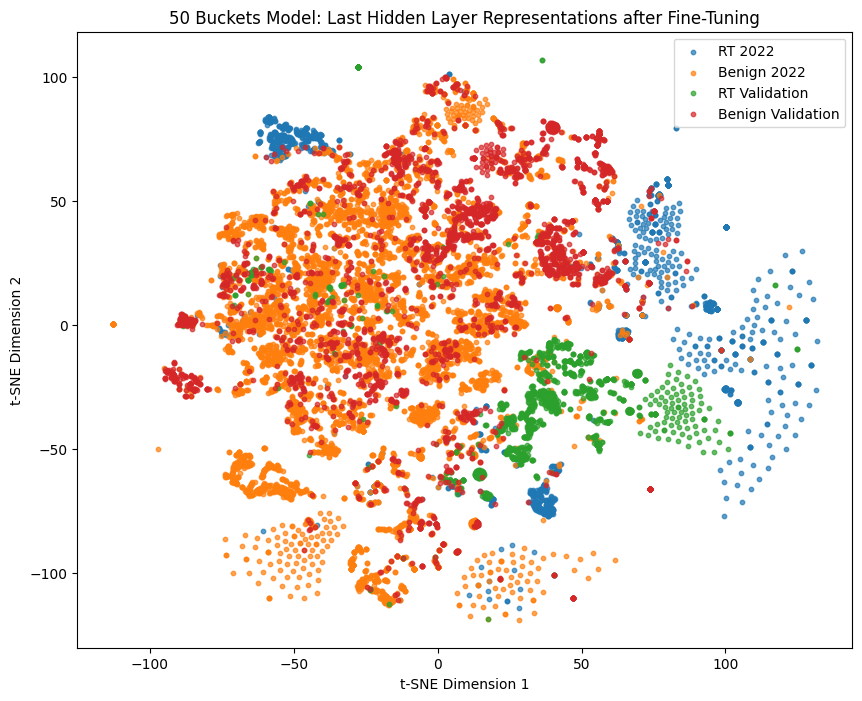

In [53]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

np.random.seed(42)
indices = np.random.choice(all_outputs.shape[0], 10000, replace=False)
embeddings_sample = all_outputs[indices]
embeddings_labels = all_labels[indices]

if validation_2020:
    embeddings_sample = np.concatenate([embeddings_sample, teamserver_outputs, benign_2020_outputs], axis=0)
    embeddings_labels = np.concatenate([embeddings_labels, [2] * len(teamserver_outputs), [3] * len(benign_2020_outputs)], axis=0)
    
    
legend = ['RT 2022', 'Benign 2022', 'RT Validation', 'Benign Validation']

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_sample)

# Plot the reduced representations
plt.figure(figsize=(10, 8))
# plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=embeddings_labels, alpha=0.7, s=10)

for i, label in enumerate(legend):
    indices = embeddings_labels == i
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], alpha=0.7, s=10, label=label)


plt.title('50 Buckets Model: Last Hidden Layer Representations after Fine-Tuning')
plt.legend()
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [54]:
counts = np.bincount(embeddings_labels)
print(f"Number of 0s: {counts[0]}")
print(f"Number of 1s: {counts[1]}")


Number of 0s: 2420
Number of 1s: 7580


In [39]:
from torch.utils.data import DataLoader
eval_loader = DataLoader(eval_data, batch_size=64, shuffle=False, pin_memory=False)

model.eval()
all_true_labels = []
all_logits = []
all_pred_labels = []
# iterate over the batches
for batch in tqdm.tqdm(eval_loader):
    # move the batch to the device
    labels = batch['label']
    all_true_labels.append(labels)
    batch = {k: v.to('cuda') for k, v in batch.items() if k != 'label'}
    # forward pass
    outputs = model(**batch)
    all_logits.append(outputs.logits.cpu().detach().numpy())

  0%|          | 0/1585 [00:00<?, ?it/s]

100%|██████████| 1585/1585 [02:23<00:00, 11.02it/s]


In [55]:
if validation_2020:
    teamserver_loader = DataLoader(teamserver_data, batch_size=64, shuffle=False, pin_memory=False)
    benign_2020_loader = DataLoader(benign_2020_data, batch_size=64, shuffle=False, pin_memory=False)
    
    model.eval()
    teamserver_logits = []
    # iterate over the batches
    for batch in tqdm.tqdm(teamserver_loader):
        batch = {k: v.to('cuda') for k, v in batch.items() if k != 'label'}
        outputs = model(**batch)
        teamserver_logits.append(outputs.logits.cpu().detach().numpy())
    
    benign_2020_logits = []
    # iterate over the batches
    i = 0
    for batch in tqdm.tqdm(benign_2020_loader):
        if i > 50:
            break
        i += 1
        batch = {k: v.to('cuda') for k, v in batch.items() if k != 'label'}
        outputs = model(**batch)
        benign_2020_logits.append(outputs.logits.cpu().detach().numpy())
    
    benign_2020_logits = np.concatenate(benign_2020_logits, axis=0)
    teamserver_logits = np.concatenate(teamserver_logits, axis=0)
    teamserver_true_labels = [0] * len(teamserver_logits)
    benign_2020_true_labels = [1] * len(benign_2020_logits)
    teamserver_pred_labels = np.argmax(teamserver_logits, axis=1)
    benign_2020_pred_labels = np.argmax(benign_2020_logits, axis=1)
    all_2020_true_labels = np.concatenate([teamserver_true_labels, benign_2020_true_labels], axis=0)
    all_2020_pred_labels = np.concatenate([teamserver_pred_labels, benign_2020_pred_labels], axis=0)
    from sklearn.metrics import classification_report
    print(classification_report(all_2020_true_labels, all_2020_pred_labels, target_names=['RT', 'Benign']))

  8%|▊         | 2/24 [00:00<00:02,  8.70it/s]

  1%|          | 51/4356 [00:04<06:26, 11.13it/s]

              precision    recall  f1-score   support

          RT       0.24      0.07      0.11      1477
      Benign       0.68      0.89      0.77      3264

    accuracy                           0.64      4741
   macro avg       0.46      0.48      0.44      4741
weighted avg       0.54      0.64      0.57      4741



In [41]:
all_logits = np.concatenate(all_logits, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

# convert logits to labels
all_pred_labels = np.argmax(all_logits, axis=1)

In [42]:
import torch

softmax = torch.nn.Softmax(dim=1)
all_logits_softmax = softmax(torch.Tensor(all_logits))

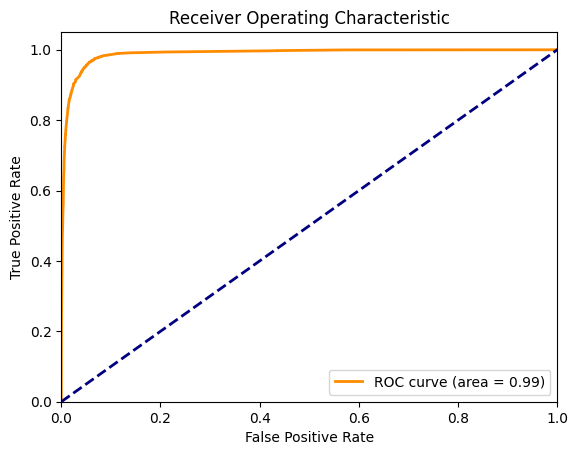

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(all_true_labels, all_logits_softmax[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [44]:
all_pred_labels_precise = (all_logits_softmax[:, 0] < 0.99).numpy().astype(int)

In [45]:
from sklearn.metrics import classification_report

print(classification_report(all_true_labels, all_pred_labels))


              precision    recall  f1-score   support

           0       0.95      0.90      0.93     24466
           1       0.97      0.99      0.98     76971

    accuracy                           0.97    101437
   macro avg       0.96      0.94      0.95    101437
weighted avg       0.97      0.97      0.97    101437



### Use SVM with hidden layer embeddings (without fine-tuning)

In [13]:
from transformers import AutoModel
model = AutoModel.from_pretrained(pretrained_model_path)
model.to('cuda')
model.eval()
pass

In [14]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

# Create DataLoader for training and validation data
train_loader = DataLoader(train_data, batch_size=128, shuffle=False, pin_memory=False)
valid_loader = DataLoader(eval_data, batch_size=128, shuffle=False, pin_memory=False)

# Function to create embeddings
def create_embeddings(loader):
    model.eval()
    embeddings = []
    labels = []
    for batch in tqdm.tqdm(loader):
        labels.extend(batch['label'].numpy())
        batch = {k: v.to('cuda') for k, v in batch.items() if k != 'label'}
        with torch.no_grad():
            outputs = model.base_model(**batch)
        embeddings.extend(outputs.last_hidden_state[:,0,:].cpu().numpy())
    return np.array(embeddings), np.array(labels)

# Create embeddings for training and validation data
train_embeddings, train_labels = create_embeddings(train_loader)
valid_embeddings, valid_labels = create_embeddings(valid_loader)

  0%|          | 0/3125 [00:00<?, ?it/s]

100%|██████████| 775/775 [00:59<00:00, 13.08it/s]


In [15]:
if validation_2020:
    teamserver_loader = DataLoader(teamserver_data, batch_size=64, shuffle=True, pin_memory=False)
    benign_2020_loader = DataLoader(benign_2020_data, batch_size=64, shuffle=True, pin_memory=False)
    
    model.eval()
    teamserver_outputs = []
    # iterate over the batches
    for batch in tqdm.tqdm(teamserver_loader):
        batch = {k: v.to('cuda') for k, v in batch.items() if k != 'label'}
        with torch.no_grad():
            outputs = model.base_model(**batch)
        teamserver_outputs.append(outputs.last_hidden_state[:,0,:].cpu().detach().numpy())
    teamserver_outputs = np.concatenate(teamserver_outputs, axis=0)
    
    benign_2020_outputs = []
    # iterate over the batches
    i = 0
    for batch in tqdm.tqdm(benign_2020_loader):
        if i > 50:
            break
        i += 1
        batch = {k: v.to('cuda') for k, v in batch.items() if k != 'label'}
        with torch.no_grad():
            outputs = model.base_model(**batch)
        benign_2020_outputs.append(outputs.last_hidden_state[:,0,:].cpu().detach().numpy())
    benign_2020_outputs = np.concatenate(benign_2020_outputs, axis=0)

  1%|          | 51/4356 [00:01<02:45, 26.05it/s]


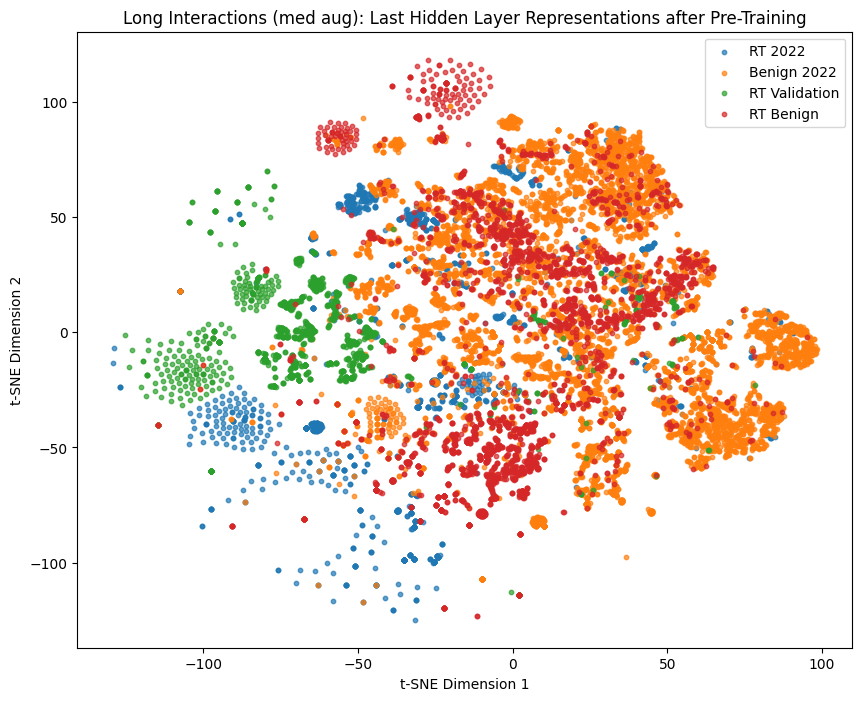

In [17]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

np.random.seed(42)
indices = np.random.choice(valid_embeddings.shape[0], 10000, replace=False)
embeddings_sample = valid_embeddings[indices]
embeddings_labels = valid_labels[indices]

if validation_2020:
    embeddings_sample = np.concatenate([embeddings_sample, teamserver_outputs, benign_2020_outputs], axis=0)
    embeddings_labels = np.concatenate([embeddings_labels, [2] * len(teamserver_outputs), [3] * len(benign_2020_outputs)], axis=0)
    
legend = ['RT 2022', 'Benign 2022', 'RT Validation', 'Benign Validation']

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_sample)

# Plot the reduced representations
plt.figure(figsize=(10, 8))
# plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=embeddings_labels, alpha=0.7, s=10)

for i, label in enumerate(legend):
    indices = embeddings_labels == i
    plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], alpha=0.7, s=10, label=label)


plt.title('Long Interactions (med aug): Last Hidden Layer Representations after Pre-Training')
plt.legend()
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [ ]:
print("hello")

hello


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

# Use train_embeddings as X and train_labels as y
X = train_embeddings
y = train_labels
n_samples_per_class = 5000 # min(np.bincount(y))

# Separate majority and minority classes
X_0 = X[y == 0]
X_1 = X[y == 1]

# Downsample majority class and upsample minority class
X_0_downsampled = resample(X_0, replace=False, n_samples=n_samples_per_class, random_state=42)
X_1_downsampled = resample(X_1, replace=False, n_samples=n_samples_per_class, random_state=42)

# Combine downsampled majority class with minority class
X_downsampled = np.concatenate([X_0_downsampled, X_1_downsampled], axis=0)

# Create corresponding y labels
y_downsampled = np.array([0]*n_samples_per_class + [1]*n_samples_per_class)

# Use X_downsampled and y_downsampled for training
X = X_downsampled
y = y_downsampled

# shuffle
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# # Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# # train a svm for comparison
from sklearn.svm import SVC
clf_svm = SVC(random_state=42)
clf_svm.fit(X, y)

# train a mlp for comparison
# from sklearn.neural_network import MLPClassifier
# # use one hidden layer with 100 neurons
# clf_mlp = MLPClassifier(random_state=42, verbose=True)
# clf_mlp.fit(X, y)

# Predict on validation data
valid_preds = clf.predict(valid_embeddings)
valid_preds_svm = clf_svm.predict(valid_embeddings)
# valid_preds_mlp = clf_mlp.predict(valid_embeddings)


# Print classification report
print(classification_report(valid_labels, valid_preds))
print("---------------------------------")
print(classification_report(valid_labels, valid_preds_svm))
print("---------------------------------")
# print(classification_report(valid_labels, valid_preds_mlp))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     22765
           1       0.98      0.97      0.98     76308

    accuracy                           0.96     99073
   macro avg       0.95      0.95      0.95     99073
weighted avg       0.96      0.96      0.96     99073

---------------------------------
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     22765
           1       0.98      0.97      0.97     76308

    accuracy                           0.96     99073
   macro avg       0.93      0.94      0.94     99073
weighted avg       0.96      0.96      0.96     99073

---------------------------------


In [20]:
teamserver_preds = clf.predict(teamserver_outputs)
benign_preds_2020 = clf.predict(benign_2020_outputs)
all_preds_2020 = np.concatenate([teamserver_preds, benign_preds_2020], axis=0)
all_labels_2020 = np.concatenate([np.zeros(len(teamserver_preds)), np.ones(len(benign_preds_2020))], axis=0)

# svm
teamserver_preds = clf_svm.predict(teamserver_outputs)
benign_preds_2020 = clf_svm.predict(benign_2020_outputs)
all_preds_2020_svm = np.concatenate([teamserver_preds, benign_preds_2020], axis=0)

print(classification_report(all_labels_2020, all_preds_2020))
print("---------------------------------")
print(classification_report(all_labels_2020, all_preds_2020_svm))

              precision    recall  f1-score   support

         0.0       0.75      0.19      0.31      1477
         1.0       0.73      0.97      0.83      3264

    accuracy                           0.73      4741
   macro avg       0.74      0.58      0.57      4741
weighted avg       0.73      0.73      0.67      4741

---------------------------------
              precision    recall  f1-score   support

         0.0       0.59      0.27      0.37      1477
         1.0       0.74      0.92      0.82      3264

    accuracy                           0.72      4741
   macro avg       0.67      0.59      0.59      4741
weighted avg       0.69      0.72      0.68      4741



In [ ]:
# Predict on training data
train_preds_rf = clf.predict(train_embeddings)
# train_preds_svm = clf_svm.predict(train_embeddings)

# Print classification report
print("Classification report for Random Forest:")
print(classification_report(train_labels, train_preds_rf))
print("---------------------------------")
# print("Classification report for SVM:")
# print(classification_report(train_labels, train_preds_svm))
